<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [22]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2026.02.0':
    print('installing pyTEMlib')
   
    !{sys.executable} -m pip install pyTEMlib -q --upgrade

# ------------------------------
print('done')

installing pyTEMlib
done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [96]:
def get_absorption(z, thickness, energy_scale):
    """ Calculate absorption for material with atomic number z and thickness t in m"""
    x_sections = pyTEMlib.eels_tools.get_x_sections()
    photoabsorption = x_sections[str(z)]['dat']/1e10/x_sections[str(z)]['photoabs_to_sigma']
    lin = scipy.interpolate.interp1d(x_sections[str(z)]['ene'], photoabsorption, kind='linear')
    mu = lin(energy_scale) * x_sections[str(z)]['nominal_density']*100  #1/cm -> 1/m
    return np.exp(-mu * thickness)

def get_absorption_correction(spectrum, thickness=50):
    """
    Calculate absorption correction for all elements in the spectrum based on thickness t in nm
    Updates the element in spectrum.metadata['EDS']['GUI'] dictionary
    Parameters:
    - spectrum: A sidpy.Dataset object containing the spectral data and metadata.
    - t: Thickness in nm
    Returns:
        None
    """
    start_channel = np.searchsorted(spectrum.energy_scale.values, 120)
    absorption = spectrum.energy_scale.values[start_channel:]*0.
    take_off_angle = spectrum.metadata['EDS']['detector'].get('ElevationAngle', 0)
    path_length = thickness / np.cos(take_off_angle) * 1e-9 # *5 /2?    in m
    count = 1
    for element, lines in spectrum.metadata['EDS']['GUI'].items():
        part = lines['atom%']/100
        if part > 0 :
            count += 1
        absorption += get_absorption(pyTEMlib.utilities.get_atomic_number(element), path_length*part, spectrum.energy_scale[start_channel:])
        
    for element, lines in spectrum.metadata['EDS']['GUI'].items():    
        symmetry = 'K-family' # lines['symmetry']
        peaks = spectrum.metadata['EDS'][element][symmetry]['peaks'][start_channel:] *absorption/count
        lines['absorption'] = peaks.sum()
        lines['thickness'] = thickness


def apply_absorption_correction(spectrum, thickness):
    """ 
    Apply Absorption Correction to Quantification
    Updates the element in spectrum.metadata['EDS']['GUI'] dictionary
    Parameters:
    - spectrum: A sidpy.Dataset object containing the spectral data and metadata.
    - thickness: Thickness in nm
    Returns:
        None
    """
    get_absorption_correction(spectrum, thickness)

    atom_sum = 0.
    weight_sum = 0.
    for element, lines in spectrum.metadata['EDS']['GUI'].items():
        atom_sum += lines['atom%'] * lines['absorption']
        weight_sum += lines['weight%'] * lines['absorption']
    for element, lines in spectrum.metadata['EDS']['GUI'].items():
        lines['corrected-atom%'] = lines['atom%'] * lines['absorption'] / atom_sum*100
        lines['corrected-weight%'] = lines['weight%'] * lines['absorption'] / weight_sum*100

        
apply_absorption_correction(spectrum, 120)
for key, value in spectrum.metadata['EDS']['GUI'].items():
    if 'corrected-atom%' in value:
        print(f'Element: {key}, Corrected Atom%: {value['corrected-atom%']:.2f}, Corrected Weight%: {value['corrected-weight%']:.2f}')


Element: Sr, Corrected Atom%: 21.65, Corrected Weight%: 46.23
Element: O, Corrected Atom%: 48.47, Corrected Weight%: 18.90
Element: Ti, Corrected Atom%: 29.88, Corrected Weight%: 34.87
Element: Cu, Corrected Atom%: 0.00, Corrected Weight%: 0.00


In [95]:
np.searchsorted(spectrum.energy_scale.values, 120)

np.int64(37)

In [128]:
spectrum.metadata['EDS']['GUI']
np.degrees(spectrum.metadata['EDS']['detector']['ElevationAngle'])



np.float64(18.0000002659109)

In [1]:
%matplotlib widget
import numpy as np
import scipy

import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

%load_ext autoreload
%autoreload 2
import sys 
sys.path.insert(0, '../../')
import pyTEMlib.eds_xsections
import pyTEMlib

# using  pyTEMlib.eds_tools, pyTEMlib.file_tools and pyTEMlib.eels_tools (for line definitions)
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2025_09_23'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
pyTEM version:  0.2025.09.3


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [14]:
fileWidget = pyTEMlib.file_tools.FileWidget(extension='.txt')

In [15]:
data_chooser = pyTEMlib.file_tools.ChooseDataset(fileWidget.datasets)

Dropdown(description='select dataset:', options=('SuperX: EDS_SuperX',), value='SuperX: EDS_SuperX')

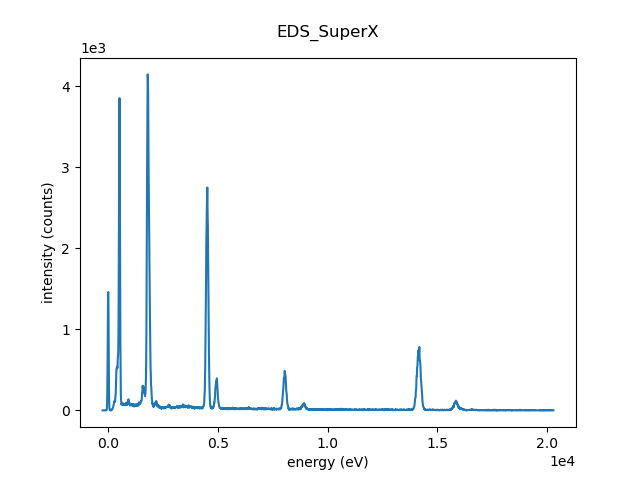

In [16]:
view = data_chooser.dataset.plot()

### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

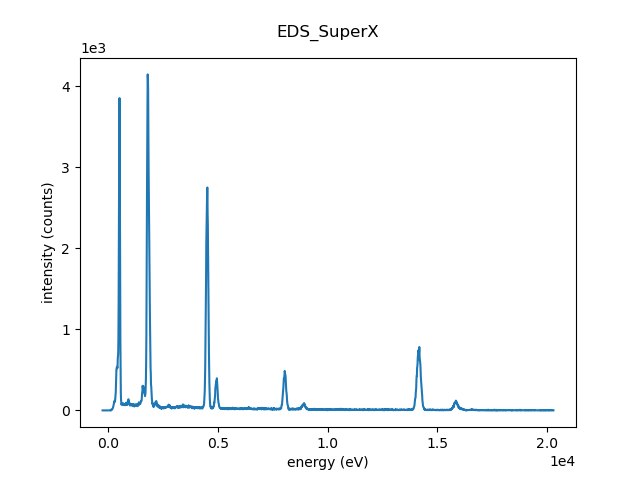

In [17]:
spectrum = fileWidget.selected_dataset
import pyTEMlib.eds_xsections
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
if 'start_energy' not in spectrum.metadata['EDS']['detector']:
    spectrum.metadata['EDS']['detector']['start_energy'] = 120
spectrum[:np.searchsorted(spectrum.energy_scale.values,spectrum.metadata['EDS']['detector']['start_energy'])] = 0.
spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency
view = spectrum.plot()

## Find Elements 

c:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\array\core.py:1744: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


['Sr', 'O', 'Ti', 'Cu']


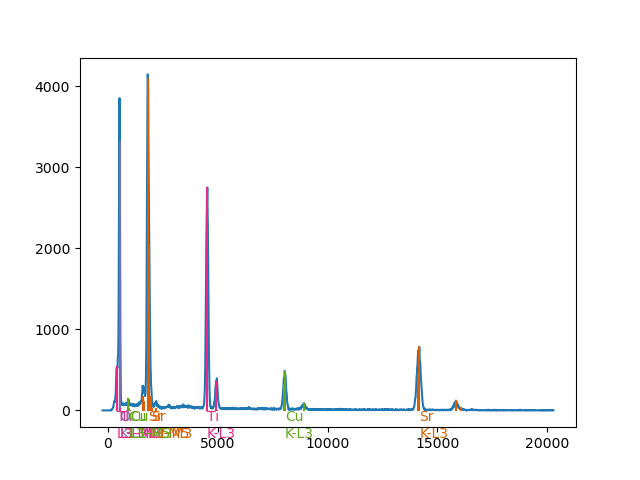

In [18]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------
minor_peaks = pyTEMlib.eds_tools.detect_peaks(spectrum, minimum_number_of_peaks=minimum_number_of_peaks)

keys = list(spectrum.metadata['EDS'].keys())
for key in keys:
    if len(key) < 3:
        del spectrum.metadata['EDS'][key]

elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)

print(elements) 
spectrum.metadata['EDS'].update(pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements))
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())


## Quantify

### Fit spectrum

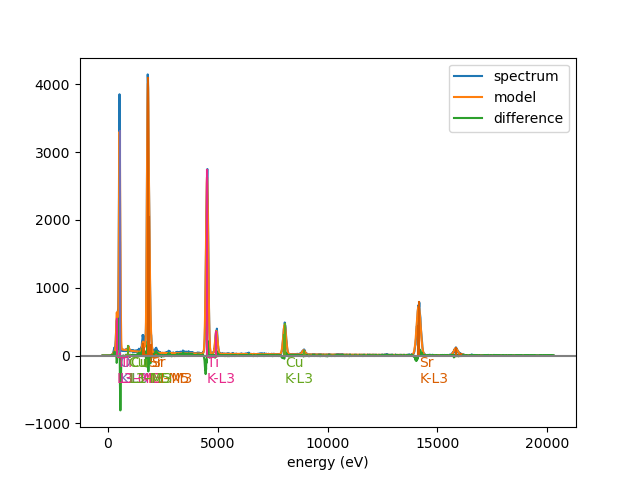

In [98]:
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, spectrum-model, label='difference')
plt.xlabel('energy (eV)')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend()

### Quantify Spectrum
first with Bote-Salvat cross section

In [101]:
pyTEMlib.eds_tools.quantify_EDS(spectrum, mask =['Cu'])

using cross sections for quantification
Sr: 20.57 at% 45.29 wt%
O : 51.02 at% 20.51 wt%
Ti: 28.42 at% 34.20 wt%


In [102]:
pyTEMlib.eds_tools.apply_absorption_correction(spectrum, 120)
for key, value in spectrum.metadata['EDS']['GUI'].items():
    if 'corrected-atom%' in value:
        print(f'Element: {key}, Corrected Atom%: {value['corrected-atom%']:.2f}, Corrected Weight%: {value['corrected-weight%']:.2f}')


Element: Sr, Corrected Atom%: 21.65, Corrected Weight%: 46.23
Element: O, Corrected Atom%: 48.47, Corrected Weight%: 18.90
Element: Ti, Corrected Atom%: 29.88, Corrected Weight%: 34.87
Element: Cu, Corrected Atom%: 0.00, Corrected Weight%: 0.00


In [24]:
dir(pyTEMlib.utilities)

['ELECTRON_REST_ENERGY',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'all_edges',
 'effective_collection_angle',
 'elements',
 'first_close_edges',
 'gauss',
 'get_atomic_number',
 'get_spectrum',
 'get_wave_length',
 'get_x_sections',
 'get_z',
 'jit',
 'lorentz',
 'major_edges',
 'np',
 'scipy',
 'second_derivative',
 'set_default_metadata',
 'shell_occupancy',
 'sidpy',
 'typing',
 'x_sections']

In [38]:
elements_list = pyTEMlib.utilities.elements

def quantify_EDS(spectrum, quantification_dict=None, mask=['Cu'] ):
    """Calculate quantification for EDS spectrum with either k-factors or cross sections."""

    for key in spectrum.metadata['EDS']:
        element = 0
        if isinstance(spectrum.metadata['EDS'][key], dict) and key in elements_list:
            element = spectrum.metadata['EDS'][key].get('Z', 0)
        if element < 1:
            continue
        if quantification_dict is None:
            quantification_dict = {}

        edge_info = pyTEMlib.eels_tools.get_x_sections(element)
        spectrum.metadata['EDS'][key]['atomic_weight'] = edge_info['atomic_weight']
        spectrum.metadata['EDS'][key]['nominal_density'] = edge_info['nominal_density']

        for family, item in edge_info['fluorescent_yield'].items():
            spectrum.metadata['EDS'][key][f"{family}-family"
                                          ]['fluorescent_yield'] = item
        if quantification_dict.get('metadata', {}).get('type', '') == 'k_factor':
            k_factors = quantification_dict.get('table', {})
            add_k_factors(spectrum.metadata['EDS'][key], key, k_factors)

    if quantification_dict is None:
        print('using cross sections for quantification')
        quantify_cross_section(spectrum, None, mask=mask)
    elif not isinstance(quantification_dict, dict):
        pass
    elif quantification_dict.get('metadata', {}).get('type', '') == 'k_factor':
        print('using k-factors for quantification')
        quantification_k_factors(spectrum, mask=mask)  # , quantification_dict['table'],
    elif quantification_dict.get('metadata', {}).get('type', '') == 'cross_section':
        print('using cross sections for quantification')
        quantify_cross_section(spectrum, quantification_dict['table'], mask=mask)
    else:
        print('using cross sections for quantification')
        quantify_cross_section(spectrum, None, mask=mask)
        # print('Need either k-factor or cross section dictionary')

def quantify_cross_section(spectrum, x_section=None, mask=None):
    """Calculate quantification for EDS spectrum with cross sections."""
    spectrum.metadata['EDS'].setdefault('GUI', {})
    acceleration_voltage = spectrum.metadata.get('experiment', {}).get('acceleration_voltage',
                                                                       200000)
    families = pyTEMlib.eds_xsections.get_families(spectrum)
    total = 0
    total_amu = 0
    for key, family in families.items():
        if key in mask:
            continue
        amu = spectrum.metadata['EDS'][key]['atomic_weight']
        intensity  = spectrum.metadata['EDS'][key][family['symmetry']].get('areal_density', 0)
        z = pyTEMlib.utilities.get_atomic_number(key)
        peaks = spectrum.metadata['EDS'][key][family['symmetry']].get('peaks', np.array([1]))
        f_yield = spectrum.metadata['EDS'][key][family['symmetry']].get('fluorescent_yield',0)
        tags = {'atomic_number':z}
        cross_sections = pyTEMlib.eds_xsections.family_ionization(z,  acceleration_voltage)
        
        x_sect = cross_sections['K-family']*1e14 
        print('x', x_sect)
        # x_sect = get_cross_section(x_section[str(z)], family['symmetry'],
        #                            acceleration_voltage)*1e14/ f_yield/peaks.max()
        spectrum.metadata['EDS']['GUI'][key]['cross_section'] = x_sect
        spectrum.metadata['EDS']['GUI'][key]['composition_counts'] = intensity*x_sect/peaks.max()
        # print(key, ' - ', family['symmetry'], intensity,  x_sect,  f_yield, peaks.max())

        total += intensity * x_sect
        total_amu += intensity * x_sect * amu

    for key, family in families.items():
        intensity  = spectrum.metadata['EDS'][key][family['symmetry']].get('areal_density', 0)
        if key in mask:
            spectrum.metadata['EDS']['GUI'][key] = {'atom%': 0,
                                                    'weight%': 0,
                                                    'excluded': True,
                                                    'intensity': intensity,
                                                    'symmetry': family['symmetry']}
            continue
        amu = spectrum.metadata['EDS'][key]['atomic_weight']
        x_sect = spectrum.metadata['EDS']['GUI'][key]['cross_section']
        spectrum.metadata['EDS']['GUI'][key] = {'atom%': intensity*x_sect/total*100,
                                                'weight%': intensity*x_sect*amu/total_amu*100,
                                                'excluded': False,
                                                'intensity': intensity,
                                                'symmetry': family['symmetry']}
        element = spectrum.metadata['EDS']['GUI'][key]
        out_text = f"{key:2}: {element['atom%']:.2f} at% {element['weight%']:.2f} wt%"
        print(out_text)


quantify_EDS(spectrum, mask =['Cu'])

using cross sections for quantification
x 5.209071650532284e-09
x 7.329971982898228e-09
x 1.139408743888624e-08
O : 22.71 at% 7.58 wt%
Sr: 18.30 at% 33.46 wt%
Ti: 58.99 at% 58.96 wt%


In [304]:
q_dict = pyTEMlib.eds_tools.load_k_factors()
tags = pyTEMlib.eds_tools.quantify_EDS(spectrum, q_dict, mask = ['Cu'])

using k-factors for quantification
Sr: 21.87 at% 49.34 wt%
Ti: 22.51 at% 27.74 wt%
O : 55.62 at% 22.91 wt%
excluded from quantification  ['Cu']


In [22]:
shell = 'L'
x_sections = pyTEMlib.eels_tools.get_x_sections()
total_rates = 0
for key, line in x_sections['22']['lines'].items():
    if key[0] == shell[0]:
     total_rates += line.get('weight', 0)
total_rates

x_sections['22']['lines']

{'K-L3': {'weight': 1.0, 'position': 4510.900000000001},
 'K-L2': {'weight': 0.509, 'position': 4504.900000000001},
 'K-M3': {'weight': 0.128, 'position': 4931.8},
 'K-M2': {'weight': 0.0733, 'position': 4931.8},
 'L3-M1': {'weight': 0.556, 'position': 395.2},
 'L2-M3': {'weight': 9.85e-05, 'position': 426.9},
 'L2-M1': {'weight': 0.272, 'position': 401.2},
 'L1-M3': {'weight': 0.00654, 'position': 529.0999999999999},
 'L1-M2': {'weight': 0.0173, 'position': 529.0999999999999}}

In [187]:
def get_bote_salvat_dict(z=0):
    filename = os.path.join(pyTEMlib.config_path, 'xrays_X_section_200kV.json')
    x_sections = json.load(open(filename))
    if z > 0:
        return x_sections['table'][str(z)]
    return x_sections
def get_line_strength(z, shell):
    x_section =  get_bote_salvat_dict(z)
    cs = 0
    for key,item in x_section.items():
        if key[0] == shell[0]:
            cs+= item['cs']
    return cs
    

In [295]:
o = {}
total = 0.
for key, item in spectrum.metadata['EDS']['GUI'].items():
    if key == 'Cu':
        print(key, ' excluded')
        continue
    intensity = item['intensity']
    z = pyTEMlib.utilities.get_z(key)
    cs = get_line_strength(z, 'K')
    print(key, cs*10e21, intensity,  intensity/ cs*10e-21)
    p_k = (spectrum.metadata['EDS'][key]['K-family']['peaks'][37:]*absorption).sum()
    
    o[key] = intensity/ cs*10e-21
    total += intensity/ cs*10e-21
for key in o:
    print(key, o[key]/total)

Sr 0.7368982518069231 18844.421973298482 2557262.4072713857
Cu  excluded
Ti 1.1060835598434287 39087.780103385885 3533890.342689746
O 0.518801764331399 32912.01278683663 6343851.360885729
Sr 0.20973724492236007
Ti 0.28970663893524956
O 0.5005561161423905


In [296]:
cs_k =  get_line_strength(38, 'K')

cs_l = get_line_strength(38, 'L')
i_k = spectrum.metadata['EDS']['Sr']['K-family']['areal_density']
i_l = spectrum.metadata['EDS']['Sr']['L-family']['areal_density']
p_k = spectrum.metadata['EDS']['Sr']['K-family']['peaks']
p_l = spectrum.metadata['EDS']['Sr']['L-family']['peaks']
print(i_l, i_k, i_l/i_k,  cs_l / cs_k, i_k/cs_k / (i_l/cs_l))


thickness = 50
energy_scale = spectrum.get_spectral_dims(return_axis=True)[0].values
start_channel = np.searchsorted(energy_scale, 120)
absorption = energy_scale[start_channel:]*0.
take_off_angle = spectrum.metadata['EDS']['detector'].get('ElevationAngle', 0)
path_length = thickness / np.cos(take_off_angle) * 1e-9 # /2?    in m
count = 1

for element, lines in spectrum.metadata['EDS']['GUI'].items():
    part = lines['atom%']/100
    if part > 0 :
        count += 1
    absorption += get_absorption(pyTEMlib.utilities.get_atomic_number(element), path_length*part, 
                                 energy_scale[start_channel:])
p_k = (p_k[37:]*absorption).sum()
p_l = (p_l[37:]*absorption).sum()

print(p_k/4, p_l/4)
print( i_k*p_k/cs_k / (i_l*p_l/cs_l))

56215.654054666986 18844.421973298482 2.9831455766762973 2.2284490285451217 0.7470131682369896
0.9999319650300605 0.9977894163149879
0.7486172262452009


In [302]:
import pyTEMlib.eds_x_xsections

ModuleNotFoundError: No module named 'pyTEMlib.eds_x_xsections'

In [301]:
i_k = spectrum.metadata['EDS']['Sr']['K-family']['areal_density']
i_l = spectrum.metadata['EDS']['Sr']['L-family']['areal_density']

c_l = 2.1842328617436956e-22
c_k = 7.264054130304e-23
i_k/c_k / (i_l/c_l)

np.float64(1.007964919836851)

In [3]:
x_sections

NameError: name 'x_sections' is not defined

In [ ]:
1
c_k, c_l

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[87], line 1
----> 1 c_k, c_l

NameError: name 'c_l' is not defined

1
import pyTEMlib.eds_x_xsections

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
Cell In[88], line 1
----> 1 import pyTEMlib.eds_x_xsections

ModuleNotFoundError: No module named 'pyTEMlib.eds_x_xsections'

1
shell_list[0] = 'K'
bote_salvat_xsection
8
Python 3 (ipykernel) | Idle
Mode: Command
Ln 14, Col 5
emission.ipynb
1

## Summary
The spectrum is modeled completely with background and characteristic peak-families.

Either 
- k-factors in a file (here from Spectra300) or
- Bothe-Salvat cross-sections
 
are used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.
